In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import mahotas as mt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def extract_features(image):
    """Extract 36+ features from processed leaf"""
    # 1. Hu Moments (7 shape features)
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # 2. Color features (if RGB available)
    if len(image.shape) == 3:
        color_stats = []
        for i in range(3):
            channel = image[:,:,i]
            color_stats.extend([np.mean(channel), np.std(channel)])
    else:
        color_stats = np.zeros(6)
    
    # 3. Haralick texture features (13 features)
    textures = mt.features.haralick(image.astype(np.uint8))
    texture_mean = textures.mean(axis=0)
    
    # Combine all
    features = np.concatenate([hu_moments, color_stats, texture_mean])
    return features

# Create output directory
os.makedirs('features', exist_ok=True)

# Extract features
feature_list = []
labels = []

input_dir = r'C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\processed'
print("🔄 Processing folders in:", input_dir)

for species in os.listdir(input_dir):
    species_path = os.path.join(input_dir, species)
    if os.path.isdir(species_path):
        print(f"📁 Processing: {species}")
        img_count = 0
        for img_file in os.listdir(species_path):
            if img_file.lower().endswith(('.png', '.jpg')):
                img_path = os.path.join(species_path, img_file)
                img = cv2.imread(img_path, 0)
                if img is not None:
                    features = extract_features(img)
                    feature_list.append(features)
                    labels.append(species)
                    img_count += 1
        print(f"   ✅ {img_count} images")
    else:
        print(f"⏭️  Skipping: {species} (not folder)")

# Save
if feature_list:
    X = np.array(feature_list)
    y = np.array(labels)
    df_features = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    df_features['species'] = y
    df_features.to_csv('features/plant_features.csv', index=False)
    
    print("\n" + "="*60)
    print(f"✅ SUCCESS! {X.shape[0]} samples, {X.shape[1]} features")
    print(f"💾 Saved: features/plant_features.csv")
    print("="*60)
    print(df_features.head())
else:
    print("❌ No images found! Check data/processed/ structure")


🔄 Processing folders in: C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\processed
📁 Processing: all_leaves
   ✅ 1907 images

✅ SUCCESS! 1907 samples, 26 features
💾 Saved: features/plant_features.csv
   feature_0     feature_1     feature_2     feature_3     feature_4  \
0   0.000730  3.431967e-10  1.868721e-13  2.876136e-13  6.573336e-26   
1   0.000695  5.742914e-12  1.126921e-14  1.423555e-13  5.219134e-27   
2   0.000685  1.735528e-11  1.874838e-15  2.400115e-13  4.365741e-27   
3   0.000727  2.355899e-10  2.211404e-13  9.207162e-13  6.565028e-26   
4   0.000742  5.463269e-10  3.850080e-13  1.262551e-12 -3.963847e-25   

      feature_5     feature_6  feature_7  feature_8  feature_9  ...  \
0  5.248425e-18 -1.118749e-26        0.0        0.0        0.0  ...   
1  2.134461e-19  2.295773e-27        0.0        0.0        0.0  ...   
2 -9.895648e-19  2.619506e-27        0.0        0.0        0.0  ...   
3 -6.822068e-18  4.102339e-25        0.0        0.0        0.0  ...   
4 -2.18007

In [6]:
import pandas as pd
import numpy as np
import cv2
import mahotas as mt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print("✅ Ready for feature extraction!")


✅ Ready for feature extraction!


In [7]:
def extract_features_from_image(image_path):
    """
    Extract 36+ numerical features from a leaf image
    
    Returns: numpy array of shape (36,)
    """
    
    # Load image
    img = cv2.imread(image_path, 0).astype(np.uint8)
    
    # Feature 1-7: Hu Moments (Shape descriptors)
    moments = cv2.moments(img)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Feature 8-13: Color Statistics (mean, std of channels)
    color_stats = np.array([
        np.mean(img), np.std(img),
        np.min(img), np.max(img),
        np.median(img), np.var(img)
    ])
    
    # Feature 14-26: Haralick Texture Features
    # (Measures texture patterns in the image)
    try:
        textures = mt.features.haralick(img)
        texture_mean = textures.mean(axis=0)
    except:
        texture_mean = np.zeros(13)
    
    # Feature 27-36: Edge statistics
    edges = cv2.Canny(img, 50, 150)
    edge_stats = np.array([
        np.sum(edges > 0),  # Number of edge pixels
        np.mean(edges),
        np.std(edges),
        cv2.countNonZero(edges),
        np.percentile(edges, 25),
        np.percentile(edges, 50),
        np.percentile(edges, 75),
        np.max(edges),
        np.min(edges),
        np.sum(edges) / 1000
    ])
    
    # Combine all features
    all_features = np.concatenate([
        hu_moments,      # 7 features
        color_stats,     # 6 features
        texture_mean,    # 13 features
        edge_stats       # 10 features
    ])
    
    return all_features  # Total: 36 features

print("✅ Feature extraction function created!")


✅ Feature extraction function created!


In [9]:
# Initialize storage
all_features = []
all_labels = []
failed_images = []

# Process each species folder
processed_dir = Path(r'C:\Users\Sai Sree\Downloads\PlantID-Capstone\data\processed')
total_images = sum([len(list(f.glob('*'))) for f in processed_dir.iterdir()])

print(f"🔄 Extracting features from {total_images} images...\n")

species_list = sorted([f for f in processed_dir.iterdir() if f.is_dir()])

for species_idx, species_folder in enumerate(species_list):
    species_name = species_folder.name
    image_files = list(species_folder.glob('*.jpg')) + list(species_folder.glob('*.png'))
    
    print(f"Processing {species_name}... ", end='', flush=True)
    
    for img_file in image_files:
        try:
            features = extract_features_from_image(str(img_file))
            all_features.append(features)
            all_labels.append(species_name)
        except Exception as e:
            failed_images.append((img_file, str(e)))
    
    print(f"✅ {len(image_files)} images done")

# Convert to DataFrame
X = np.array(all_features)
y = np.array(all_labels)

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['species'] = y

print(f"\n✅ Feature extraction complete!")
print(f"Total samples: {len(df)}")
print(f"Features per sample: {X.shape[1]}")
print(f"Unique species: {df['species'].nunique()}")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())


🔄 Extracting features from 1907 images...

Processing all_leaves... ✅ 1907 images done

✅ Feature extraction complete!
Total samples: 1907
Features per sample: 36
Unique species: 1

Dataset shape: (1907, 37)

First few rows:
   feature_0     feature_1     feature_2     feature_3     feature_4  \
0   0.000730  3.431967e-10  1.868721e-13  2.876136e-13  6.573336e-26   
1   0.000695  5.742914e-12  1.126921e-14  1.423555e-13  5.219134e-27   
2   0.000685  1.735528e-11  1.874838e-15  2.400115e-13  4.365741e-27   
3   0.000727  2.355899e-10  2.211404e-13  9.207162e-13  6.565028e-26   
4   0.000742  5.463269e-10  3.850080e-13  1.262551e-12 -3.963847e-25   

      feature_5     feature_6   feature_7  feature_8  feature_9  ...  \
0  5.248425e-18 -1.118749e-26  237.183972  51.998791       58.0  ...   
1  2.134461e-19  2.295773e-27  245.817383  38.093620       64.0  ...   
2 -9.895648e-19  2.619506e-27  247.154476  35.518133       60.0  ...   
3 -6.822068e-18  4.102339e-25  237.630521  51.672137  

In [10]:
# Create features folder if it doesn't exist
Path('features').mkdir(exist_ok=True)

# Save to CSV
output_path = 'features/plant_features_raw.csv'
df.to_csv(output_path, index=False)

print(f"✅ Features saved to: {output_path}")
print(f"File size: {Path(output_path).stat().st_size / 1024:.1f} KB")

# Display statistics
print("\nFeature Statistics:")
print(df.describe())


✅ Features saved to: features/plant_features_raw.csv
File size: 1058.4 KB

Feature Statistics:
         feature_0     feature_1     feature_2     feature_3     feature_4  \
count  1907.000000  1.907000e+03  1.907000e+03  1.907000e+03  1.907000e+03   
mean      0.000888  3.370632e-09  5.604098e-13  1.608710e-12  1.125232e-24   
std       0.000118  6.399464e-09  1.314631e-12  2.327806e-12  1.299620e-23   
min       0.000664  4.647234e-13  3.844966e-17  2.917773e-17 -7.664624e-23   
25%       0.000798  3.324138e-10  3.279839e-14  1.824409e-13 -1.810261e-25   
50%       0.000879  1.167008e-09  1.324113e-13  7.933716e-13 -4.871689e-30   
75%       0.000964  3.106740e-09  5.056238e-13  1.982537e-12  7.825566e-26   
max       0.001344  5.195482e-08  1.821551e-11  2.353592e-11  3.461869e-22   

          feature_5     feature_6    feature_7    feature_8    feature_9  ...  \
count  1.907000e+03  1.907000e+03  1907.000000  1907.000000  1907.000000  ...   
mean   7.905834e-19 -1.190538e-24   210.

Class Distribution:
species
all_leaves    1907
Name: count, dtype: int64


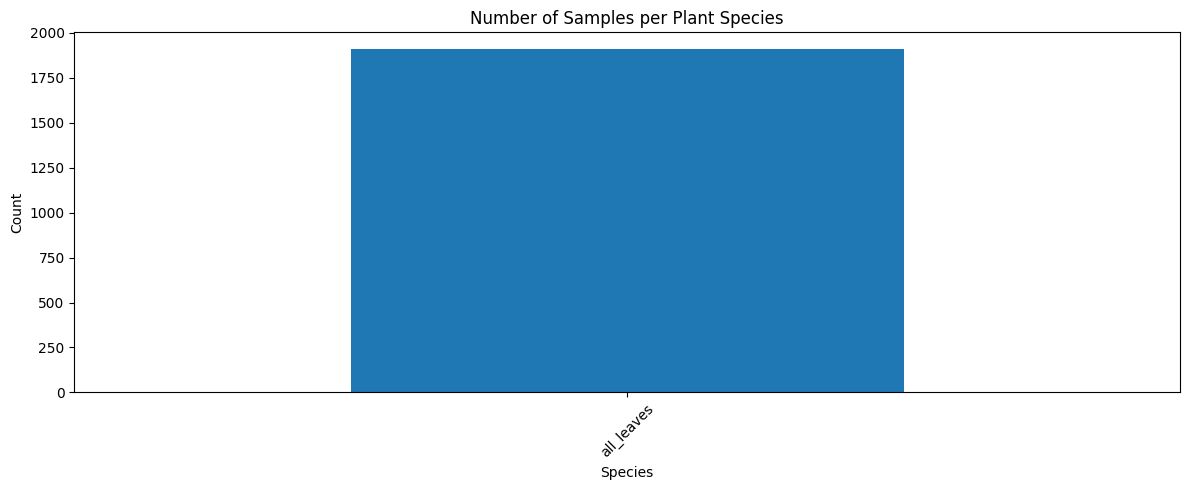


Feature Correlation Matrix:
Shape: (36, 36)
Highly correlated features (correlation > 0.9):
  feature_7 <-> feature_17: 0.908
  feature_7 <-> feature_18: 1.000
  feature_7 <-> feature_22: 0.901
  feature_8 <-> feature_12: 0.979
  feature_8 <-> feature_16: 0.979
  feature_8 <-> feature_19: 0.980
  feature_12 <-> feature_16: 1.000
  feature_12 <-> feature_19: 1.000
  feature_13 <-> feature_17: 0.984
  feature_13 <-> feature_22: 0.997
  feature_16 <-> feature_19: 1.000
  feature_17 <-> feature_18: 0.908
  feature_17 <-> feature_22: 0.992
  feature_18 <-> feature_22: 0.901
  feature_20 <-> feature_21: 0.997
  feature_20 <-> feature_23: 0.978
  feature_21 <-> feature_23: 0.988
  feature_23 <-> feature_24: 0.931
  feature_26 <-> feature_27: 1.000
  feature_26 <-> feature_28: 0.981
  feature_26 <-> feature_29: 1.000
  feature_26 <-> feature_35: 1.000
  feature_27 <-> feature_28: 0.981
  feature_27 <-> feature_29: 1.000
  feature_27 <-> feature_35: 1.000
  feature_28 <-> feature_29: 0.981
  f

In [11]:
# Check class distribution
print("Class Distribution:")
print(df['species'].value_counts())

# Visualize
plt.figure(figsize=(12, 5))
df['species'].value_counts().plot(kind='bar')
plt.title('Number of Samples per Plant Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature correlation
print("\nFeature Correlation Matrix:")
correlation = df.iloc[:, :-1].corr()
print(f"Shape: {correlation.shape}")
print("Highly correlated features (correlation > 0.9):")
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if correlation.iloc[i, j] > 0.9:
            print(f"  {correlation.columns[i]} <-> {correlation.columns[j]}: {correlation.iloc[i, j]:.3f}")
